## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
from dateutil.easter import easter
from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Generate Data 

In [2]:
np.random.seed(seed=42)

def generate_time_series_df(start_date, end_date, freq):
    """Generate time series sample data."""
    date_range = pd.date_range(start=start_date, end=end_date, freq=freq)

    df = pd.DataFrame(data={'ds': date_range})
    
    # Get date variables. 
    df['day_of_month'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['daysinmonth'] = df['ds'].dt.daysinmonth
    df['week'] = df['ds'].dt.week
    
    # Time Series Components. 
    ## Trend
    df['trend'] = np.power(df.index.values, 2/5)
    ## Seasonal
    df['monthly_seas'] = np.cos(2*np.pi*df['day_of_month']/df['daysinmonth'])
    df['yearly_seas'] = np.sin(2*np.pi*df['month']/3) + np.cos(2*np.pi*df['month']/4)
    df['end_of_year']= - 8*np.exp(- ((df['week'] - 51.5)/1.0)**2) \
    ## Noise 
    df['noise'] = np.random.normal(loc=0.0, scale=0.3, size=df.shape[0])
    
    # Target variable.
    df['y'] = df['trend'] \
        + df['monthly_seas'] \
        + df['yearly_seas'] \
        + df['end_of_year'] \
        + df['noise']
    
    return df

df = generate_time_series_df(
    start_date='2016-06-30', 
    end_date='2020-06-30', 
    freq='W'
)

df.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,ds,day_of_month,month,daysinmonth,week,trend,monthly_seas,yearly_seas,end_of_year,noise,y
0,2016-07-03,3,7,31,26,0.000000,0.820763,0.866025,-3.184954e-282,0.149014,1.835803
1,2016-07-10,10,7,31,27,1.000000,-0.440394,0.866025,-1.651305e-260,-0.041479,1.384152
2,2016-07-17,17,7,31,28,1.319508,-0.954139,0.866025,-1.158677e-239,0.194307,1.425701
3,2016-07-24,24,7,31,29,1.551846,0.151428,0.866025,-1.100293e-219,0.456909,3.026208
4,2016-07-31,31,7,31,30,1.741101,1.000000,0.866025,-1.414053e-200,-0.070246,3.536881


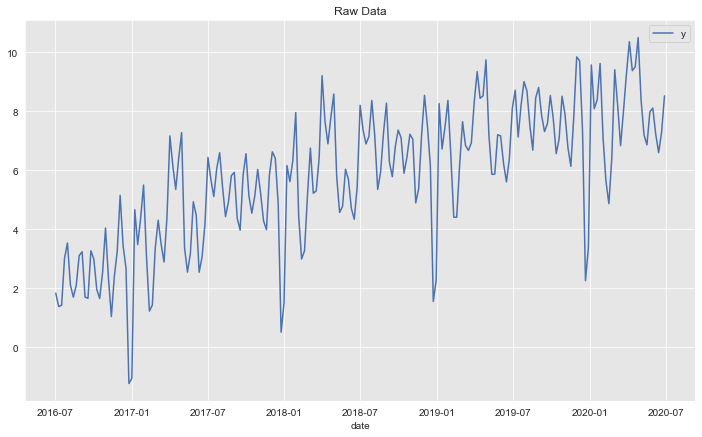

In [3]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y', data=df, ax=ax)
ax.set(title='Raw Data', xlabel='date', ylabel='');

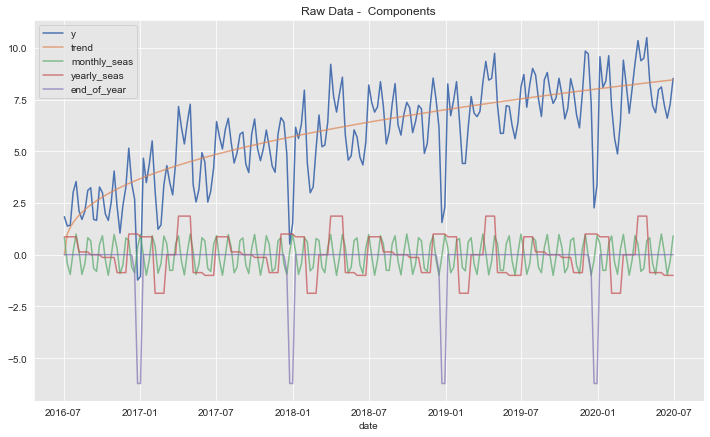

In [4]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y', data=df, ax=ax)
sns.lineplot(x='ds', y='trend', label='trend', data=df, alpha=0.7, ax=ax)
sns.lineplot(x='ds', y='monthly_seas', label='monthly_seas', data=df, alpha=0.7, ax=ax)
sns.lineplot(x='ds', y='yearly_seas', label='yearly_seas', data=df, alpha=0.7, ax=ax)
sns.lineplot(x='ds', y='end_of_year', label='end_of_year', data=df, alpha=0.7, ax=ax)
ax.set(title='Raw Data -  Components', xlabel='date', ylabel='');

## Train - Test Split

In [5]:
threshold_date = pd.to_datetime('2019-11-01')
mask = df['ds'] < threshold_date

df_train = df[mask][['ds', 'y']]
df_test = df[~ mask][['ds', 'y']]

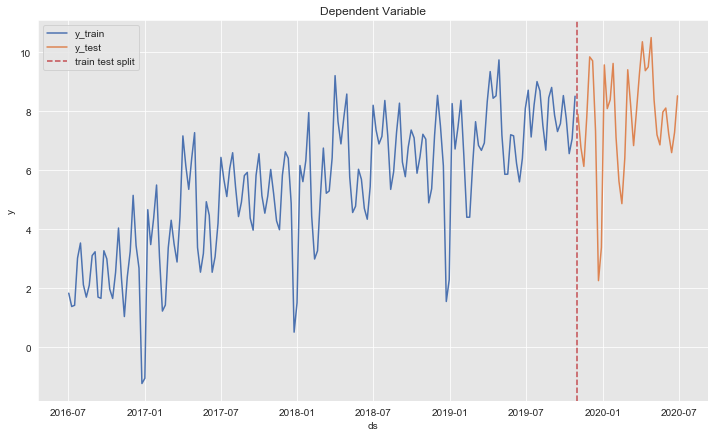

In [6]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable');

## Define Model

In [7]:
def create_end_of_year_holydays_df():
    
    holidays = pd.DataFrame({
      'holiday': 'end_of_year',
      'ds': pd.to_datetime(
          ['2016-12-26', '2017-12-26', '2018-12-26', '2019-12-26']
      ),
      'lower_window': -10,
      'upper_window': 10,
    })
    
    return holidays


def build_model():
    
    holidays = create_end_of_year_holydays_df()
    
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        holidays = holidays
    )

    model.add_seasonality(name='monthly', period=30.5, fourier_order=5) \
    
    return model
    
model = build_model()

model.fit(df_train)

/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [8]:
future = pd.concat([df_train, df_test], axis=0)[['ds']]

forecast = model.predict(df=future)

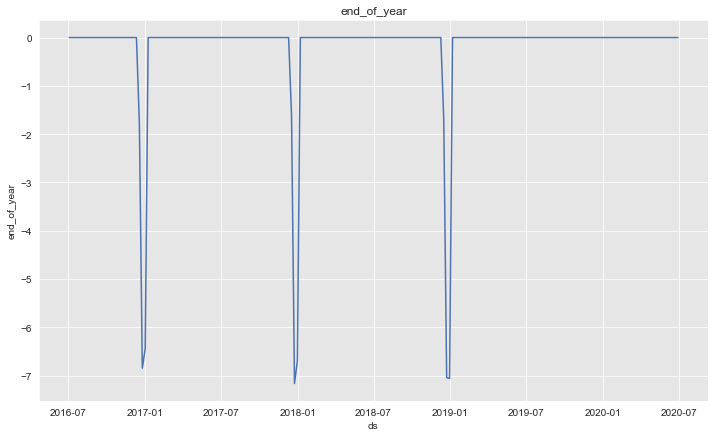

In [9]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='end_of_year', data=forecast, ax=ax)
ax.set(title='end_of_year');

In [10]:
forecast_train = forecast[mask]
forecast_test = forecast[~ mask]

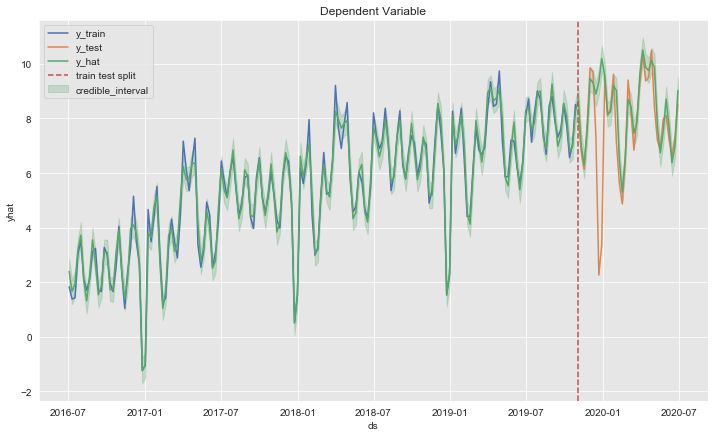

In [11]:
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable');

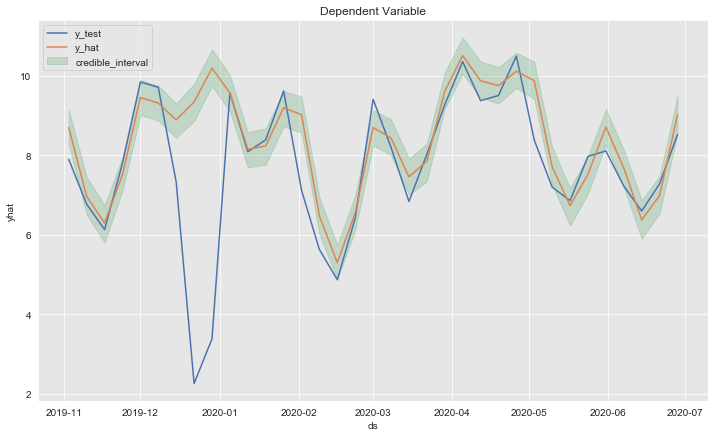

In [12]:
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Dependent Variable');

/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



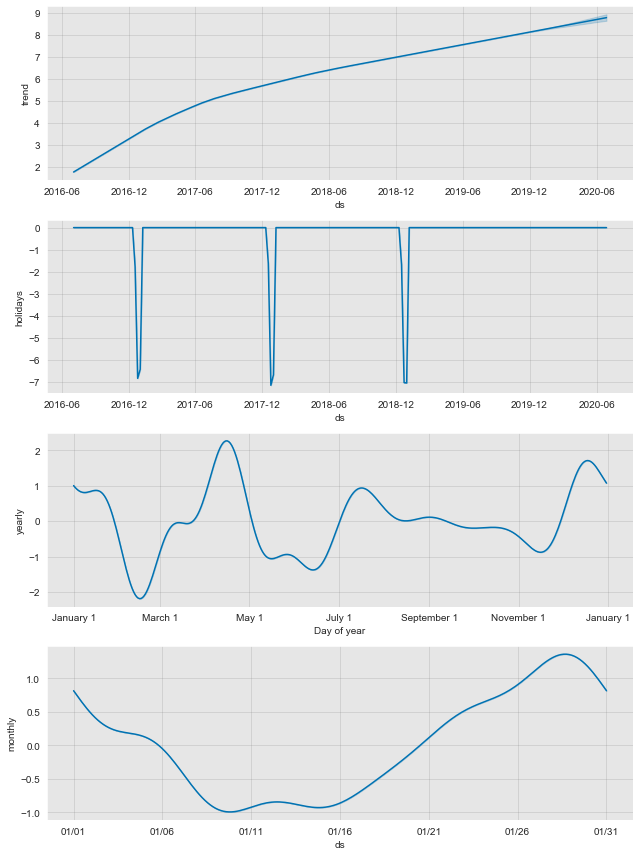

In [13]:
fig = model.plot_components(forecast)

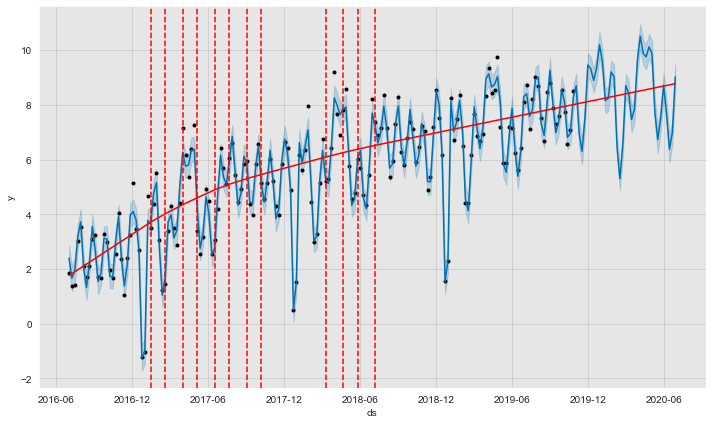

In [14]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)